This is an example of running a deep reinforcement learning algorithm.
In the following, we run Twin Delayed Deep Deterministic Policy Gradient (TD3).

# Neural Network Structure

We define classes for the actor and critic networks. In TD3, we prepare two neural networks for the critic.

In [2]:
import random
import numpy as np
import torch

def set_all_seeds(seed=1234):
    """set all random seed"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

    if torch.cuda.is_available():
        torch.cuda.empty_cache()


set_all_seeds(1234)

if torch.cuda.is_available():
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA not available, using CPU")

Using CUDA device: NVIDIA GeForce RTX 3090


In [3]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Actor(nn.Module):
	def __init__(self, state_dim, action_dim, max_action):
		super(Actor, self).__init__()

		self.l1 = nn.Linear(state_dim, 256)
		self.l2 = nn.Linear(256, 256)
		self.l3 = nn.Linear(256, action_dim)

		self.max_action = max_action


	def forward(self, state):
		a = F.relu(self.l1(state))
		a = F.relu(self.l2(a))
		return self.max_action * torch.tanh(self.l3(a))


class Critic(nn.Module):
	def __init__(self, state_dim, action_dim):
		super(Critic, self).__init__()

		# Q1 architecture
		self.l1 = nn.Linear(state_dim + action_dim, 256)
		self.l2 = nn.Linear(256, 256)
		self.l3 = nn.Linear(256, 1)

		# Q2 architecture
		self.l4 = nn.Linear(state_dim + action_dim, 256)
		self.l5 = nn.Linear(256, 256)
		self.l6 = nn.Linear(256, 1)


	def forward(self, state, action):
		sa = torch.cat([state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)

		q2 = F.relu(self.l4(sa))
		q2 = F.relu(self.l5(q2))
		q2 = self.l6(q2)
		return q1, q2


	def Q1(self, state, action):
		sa = torch.cat([state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)
		return q1


We then define the class for TD3. The update of the actor and critic is defined in "def train()".

In [4]:
class TD3(object):
	def __init__(
		self,
		state_dim,
		action_dim,
		max_action,
		discount=0.99,
		tau=0.005,
		policy_noise=0.2,
		noise_clip=0.5,
		policy_freq=2
	):

		self.actor = Actor(state_dim, action_dim, max_action).to(device)
		self.actor_target = copy.deepcopy(self.actor)
		self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)

		self.critic = Critic(state_dim, action_dim).to(device)
		self.critic_target = copy.deepcopy(self.critic)
		self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

		self.max_action = max_action
		self.discount = discount
		self.tau = tau
		self.policy_noise = policy_noise
		self.noise_clip = noise_clip
		self.policy_freq = policy_freq

		self.total_it = 0


	def select_action(self, state, test=False):
		state = torch.FloatTensor(state.reshape(1, -1)).to(device)
		return self.actor(state).cpu().data.numpy().flatten()


	def train(self, replay_buffer, batch_size=256):
		self.total_it += 1

		# Sample replay buffer
		state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

		with torch.no_grad():
			# Select action according to policy and add clipped noise
			noise = (
				torch.randn_like(action) * self.policy_noise
			).clamp(-self.noise_clip, self.noise_clip)

			next_action = (
				self.actor_target(next_state) + noise
			).clamp(-self.max_action, self.max_action)

			# Compute the target Q value
			target_Q1, target_Q2 = self.critic_target(next_state, next_action)
			target_Q = torch.min(target_Q1, target_Q2)
			target_Q = reward + not_done * self.discount * target_Q

		# Get current Q estimates
		current_Q1, current_Q2 = self.critic(state, action)

		# Compute critic loss
		critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

		# Optimize the critic
		self.critic_optimizer.zero_grad()
		critic_loss.backward()
		self.critic_optimizer.step()

		# Delayed policy updates
		if self.total_it % self.policy_freq == 0:

			# Compute actor loss
			actor_loss = -self.critic.Q1(state, self.actor(state)).mean()

			# Optimize the actor
			self.actor_optimizer.zero_grad()
			actor_loss.backward()
			self.actor_optimizer.step()

			# Update the frozen target models
			for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

			for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


	def save(self, filename):
		torch.save(self.critic.state_dict(), filename + "_critic")
		torch.save(self.critic_optimizer.state_dict(), filename + "_critic_optimizer")
		torch.save(self.actor.state_dict(), filename + "_actor")
		torch.save(self.actor_optimizer.state_dict(), filename + "_actor_optimizer")


	def load(self, filename):
		self.critic.load_state_dict(torch.load(filename + "_critic"))
		self.critic_optimizer.load_state_dict(torch.load(filename + "_critic_optimizer"))
		self.actor.load_state_dict(torch.load(filename + "_actor"))
		self.actor_optimizer.load_state_dict(torch.load(filename + "_actor_optimizer"))


# Replay Buffer

The samples collected through trials and errors are stored in the replay buffer. "def sample()" is a function that randomly samples a batch of samples from the replay buffer.

In [5]:
class ReplayBuffer(object):
	def __init__(self, state_dim, action_dim, max_size=int(1e6)):
		self.max_size = max_size
		self.ptr = 0
		self.size = 0

		self.state = np.zeros((max_size, state_dim))
		self.action = np.zeros((max_size, action_dim))
		self.next_state = np.zeros((max_size, state_dim))
		self.reward = np.zeros((max_size, 1))
		self.not_done = np.zeros((max_size, 1))

		self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


	def add(self, state, action, next_state, reward, done):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.next_state[self.ptr] = next_state
		self.reward[self.ptr] = reward
		self.not_done[self.ptr] = 1. - done

		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)


	def sample(self, batch_size):
		ind = np.random.randint(self.size, size=batch_size)

		return (
			torch.FloatTensor(self.state[ind]).to(self.device),
			torch.FloatTensor(self.action[ind]).to(self.device),
			torch.FloatTensor(self.next_state[ind]).to(self.device),
			torch.FloatTensor(self.reward[ind]).to(self.device),
			torch.FloatTensor(self.not_done[ind]).to(self.device)
		)

# Training and evaluating procedures

We define a function for evaluating the policy. When evaluating the trained policy, we evaluate the performance without the exploration noise.


In [6]:
def eval_policy(policy, env, seed, eval_episodes=10):
	eval_env = gym.make(env)

	avg_reward = 0.
	for _ in range(eval_episodes):
		state, info = eval_env.reset(seed=seed+eval_episodes)          # 固定评测环境
		eval_env.action_space.seed(seed+eval_episodes)
		terminated, truncated = False, False
		while not (terminated or truncated):
			action = policy.select_action(np.array(state), test=True)
			state, reward, terminated, truncated, info  = eval_env.step(action)
			avg_reward += reward

	avg_reward /= eval_episodes

	print("---------------------------------------")
	print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
	print("---------------------------------------")
	return avg_reward

Below is the training procedure. We collect samples through trials and errors and store them in the replay buffer. The policy is trained once after every one time step.

In [7]:
def train(env, agent, args, index, trial_seed):

    # Initialize replay memory
    total_step_cnt = 0
    epi_cnt = 0
    test_iter = 0
    return_test = np.zeros((np.ceil(int(args['total_step_num']) / int(args['eval_step_freq'])).astype('int') + 1))

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    replay_buffer = ReplayBuffer(state_dim, action_dim)
    episode_timesteps = 0

    while total_step_cnt in range( int(args['total_step_num']) ):

        state, info = env.reset(seed=trial_seed + epi_cnt)
        ep_reward = 0
        T_end = False

        for t in range(int(args['max_episode_len'])):

            # Select action randomly or according to policy
            if total_step_cnt < int(args['start_timesteps']):
                action = env.action_space.sample()
            else:
                action = np.clip(
                        agent.select_action(np.array(state))
                        + np.random.normal(0, max_action * float(args['expl_noise']), size=action_dim),
                        -max_action, max_action)

            next_state, reward, terminated, truncated, info = env.step(action)
            done_bool = float(terminated) if episode_timesteps < env._max_episode_steps else 0

            # Store data in replay buffer
            replay_buffer.add(state, action, next_state, reward, done_bool)

            # Train agent after collecting sufficient data
            if total_step_cnt >= int(args['start_timesteps']):
                for i in range(int(args['update_freq'])):
                    agent.train(replay_buffer, int(args['batch_size']))

            if t == int(args['max_episode_len']) - 1:
                T_end = True

            state = next_state
            ep_reward += reward
            total_step_cnt += 1

            # Evaluate the deterministic policy
            if total_step_cnt >= test_iter * int(args['eval_step_freq']) or total_step_cnt == 1:
                print('total_step_cnt', total_step_cnt)
                print('evaluating the deterministic policy...')
                for test_n in range(int(args['test_num'])):
                    return_epi_test = eval_policy(agent, args['env'], trial_seed+test_n+test_iter, eval_episodes=args['test_num'])

                    # Store the average of returns over the test episodes
                    return_test[test_iter] = return_test[test_iter] + return_epi_test / float(args['test_num'])

                print('return_test[{:d}] {:d}'.format(int(test_iter), int(return_test[test_iter])))
                test_iter += 1

            if terminated or truncated:
                epi_cnt += 1
                print('| Reward: {:d} | Episode: {:d} | Total step num: {:d} |'.format(int(ep_reward), epi_cnt, total_step_cnt ))

                break

    return return_test

Main funciton. To manage the hyperparamters of TD3, we use argeparse.
We use a task in OpenAI Gym (https://gym.openai.com/).

In [8]:
import numpy as np
import gymnasium as gym

import argparse
import random

def set_all_seeds(seed=1234):
    """set all random seed"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# 在程序开始时设置种子
set_all_seeds(1234)

if torch.cuda.is_available():
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA not available, using CPU")

parser = argparse.ArgumentParser()

# run parameters
parser.add_argument('--env', help='choose the gym env- tested on {Pendulum-v1}')
parser.add_argument('--env-id', type=int, default=0, help='choose the gym env- tested on {Pendulum-v1}')
parser.add_argument('--random-seed', help='random seed for repeatability', default=1234)
parser.add_argument('--max-episodes', help='max num of episodes to do while training', default=1001)
parser.add_argument('--max-episode-len', help='max length of 1 episode', default=1000)
parser.add_argument('--trial-num', help='number of trials', default=3)
# parser.add_argument('--render-env', help='render the gym env', action='store_true')
parser.add_argument('--total-step-num', help='total number of time steps', default=25000)
parser.add_argument('--eval-step-freq', help='frequency of evaluating the policy', default=5000)
parser.add_argument('--test-num', help='number of test episodes', default=10)

parser.add_argument('--result-file', help='file name for storing results from multiple trials',
                    default='./results/trials/td3/trials_td3_')
parser.add_argument('--trial-idx', help='index of trials', default=0)
parser.add_argument('--monitor-dir', help='directory for recording', default='results/video/td3')

parser.add_argument("--start_timesteps", default=1e4, type=int)  # How many time steps purely random policy is run for
parser.add_argument("--expl_noise", default=0.1, type=float)  # Std of Gaussian exploration noise
parser.add_argument("--batch_size", default=256, type=int)  # Batch size for both actor and critic
parser.add_argument("--update_freq", default=1, type=int)  # Number of policy updates

parser.set_defaults(render_env=False)

args_tmp, unknown = parser.parse_known_args()

if args_tmp.env is None:
    env_dict = {0 : "Pendulum-v1",
    }
    args_tmp.env = env_dict[args_tmp.env_id]
args = vars(args_tmp)

return_set=[]
for ite in range(int(args['trial_num'])):
    print('Trial Number:', ite)

    seed = 1234 + ite            
    set_all_seeds(seed)

    index = int(ite) + int(args['trial_idx'])
    env = gym.make(args['env'])
    env.reset(seed=seed)
    env.action_space.seed(seed)  # 有时 action_space 也需要显式 seed

    print('action_space.shape', env.action_space.shape)
    print('observation_space.shape', env.observation_space.shape)
    action_bound = float(env.action_space.high[0])

    assert (env.action_space.high[0] == -env.action_space.low[0])

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    agent = TD3(state_dim=state_dim, action_dim=action_dim, max_action=action_bound)

    step_R_i = train(env, agent, args, index, seed)
    return_set.append(step_R_i)

    result_path = "./results/trials/td3"
    result_filename = args['result_file'] +  \
                      '_update_freq_' + str(int(args['update_freq'])) + '_' + args['env'] +  \
                      '_trial_idx_' + str(index) + '.txt'
    try:
        import pathlib
        pathlib.Path(result_path).mkdir(parents=True, exist_ok=True)
        np.savetxt(result_filename, np.asarray(step_R_i))
        print('The result of the trial no.' + str(index) + ' was saved.')
    except:
        print("A result directory does not exist and cannot be created. The trial results are not saved")







Using CUDA device: NVIDIA GeForce RTX 3090
Trial Number: 0
action_space.shape (1,)
observation_space.shape (3,)
total_step_cnt 1
evaluating the deterministic policy...
---------------------------------------
Evaluation over 10 episodes: -1382.448
---------------------------------------
---------------------------------------
Evaluation over 10 episodes: -1280.658
---------------------------------------
---------------------------------------
Evaluation over 10 episodes: -976.828
---------------------------------------
---------------------------------------
Evaluation over 10 episodes: -978.300
---------------------------------------
---------------------------------------
Evaluation over 10 episodes: -1336.772
---------------------------------------
---------------------------------------
Evaluation over 10 episodes: -1860.920
---------------------------------------
---------------------------------------
Evaluation over 10 episodes: -988.357
---------------------------------------
--

We plot the results of the training using matplotlib.

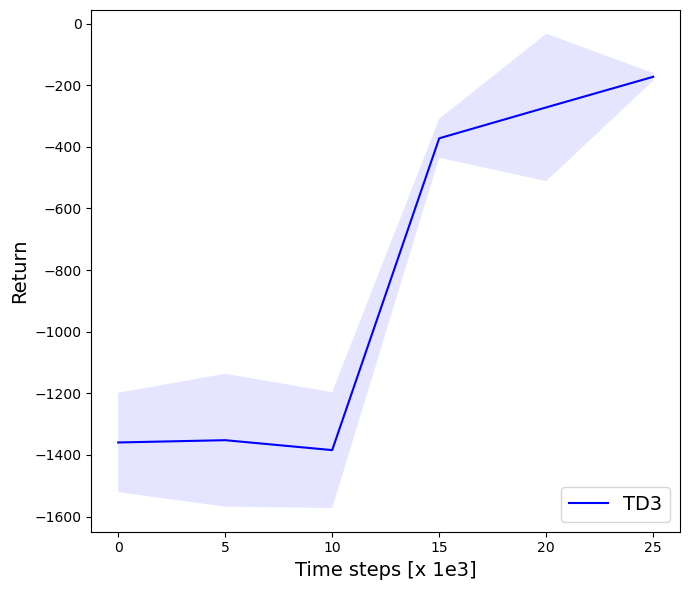

In [10]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

figure(figsize=(7, 6))

t = np.arange(0, int(args['total_step_num']) + 1, int(args['eval_step_freq'])) * 0.001

mean = np.mean(np.asarray(return_set), axis=0)
std = np.std(np.asarray(return_set), axis=0)
color = 'b'
label = 'TD3'
plt.plot(t, mean, color, label=label)
plt.fill(np.concatenate([t, t[::-1]]), np.concatenate([mean - 1.9600 * std,
                                      (mean + 1.9600 * std)[::-1]]), alpha=.1, fc=color, ec='None')

plt.xlabel('Time steps [x 1e3]', fontsize=14)
plt.ylabel('Return', fontsize=14)
plt.legend(loc='lower right', fontsize=14)


plt.tight_layout()
plt.show()

## SAC

In [ ]:
class Actor(nn.Module):
    # changed: add log_std_min, log_std_max
    def __init__(self, state_dim, action_dim, max_action, log_std_min=-20, log_std_max=2):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 256)
        self.l2 = nn.Linear(256, 256)
        # changed: SAC ：mean and log_std
        self.mean = nn.Linear(256, action_dim)
        self.log_std = nn.Linear(256, action_dim)

        # changed: record log_std upper & lower bounds
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        self.max_action = max_action

    def forward(self, state):
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(x))
        mean = self.mean(x)
        log_std = self.log_std(x)
        # changed: max
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        return mean, log_std

    # changed: SAC reparameterization and calculate log_pi
    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()

       
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()
        log_pi = normal.log_prob(x_t).sum(dim=-1, keepdim=True)

    
        action = torch.tanh(x_t)

        log_pi -= torch.log(1 - action.pow(2) + 1e-6).sum(dim=-1, keepdim=True)

        # [-max_action, max_action]
        action = self.max_action * action
        return action, log_pi, mean, log_std


In [ ]:
# Critic the same as TD3
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_dim + action_dim, 256)
        self.l5 = nn.Linear(256, 256)
        self.l6 = nn.Linear(256, 1)

    def forward(self, state, action):
        sa = torch.cat([state, action], dim=1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)

        q2 = F.relu(self.l4(sa))
        q2 = F.relu(self.l5(q2))
        q2 = self.l6(q2)
        return q1, q2

    def Q1(self, state, action):
        sa = torch.cat([state, action], dim=1)
        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)
        return q1

In [ ]:
class SAC(object):
    # changed: delete policy_noise, noise_clip, policy_freq
    #          add alpha
    def __init__(
        self,
        state_dim,
        action_dim,
        max_action,
        discount=0.7,
        tau=0.015,
        alpha=0.2,            # changed: initial alpha
        target_entropy=None,  
        automatic_entropy_tuning=True  # changed: adjust alpha
    ):

        # changed: SAC Actor
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)

        # Critic, target critic
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

        self.max_action = max_action
        self.discount = discount
        self.tau = tau

        # changed: adjust alpha
        self.automatic_entropy_tuning = automatic_entropy_tuning
        if target_entropy is None:
            self.target_entropy = -action_dim  # usually -action_dim
        else:
            self.target_entropy = target_entropy

        if self.automatic_entropy_tuning:
            # changed: log_alpha
            self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
            self.alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=3e-4)
        else:
            # changed: fix alpha
            self.log_alpha = torch.tensor(np.log(alpha)).to(device)
            self.alpha_optimizer = None

        self.total_it = 0

    # changed: SAC' select_action
    def select_action(self, state, test=False):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        if test:
            # test mean
            mean, log_std = self.actor(state)
            action = torch.tanh(mean) * self.max_action
            return action.cpu().data.numpy().flatten()
        else:
            # train random
            action, _, _, _ = self.actor.sample(state)
            return action.cpu().data.numpy().flatten()


    def train(self, replay_buffer, batch_size=256):
        self.total_it += 1

        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        with torch.no_grad():
            next_action, next_log_pi, _, _ = self.actor.sample(next_state)
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2) - self.alpha * next_log_pi
            target_Q = reward + not_done * self.discount * target_Q

        current_Q1, current_Q2 = self.critic(state, action)
        critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        a, log_pi, _, _ = self.actor.sample(state)
        Q1, Q2 = self.critic(state, a)
        Q = torch.min(Q1, Q2)
        actor_loss = (self.alpha * log_pi - Q).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        if self.automatic_entropy_tuning:
            alpha_loss = (-(self.log_alpha * (log_pi + self.target_entropy).detach())).mean()
            self.alpha_optimizer.zero_grad()
            alpha_loss.backward()
            self.alpha_optimizer.step()

        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(
                self.tau * param.data + (1 - self.tau) * target_param.data
            )

    @property
    def alpha(self):
        return self.log_alpha.exp()

    def save(self, filename):
        torch.save(self.critic.state_dict(), filename + "_critic")
        torch.save(self.critic_optimizer.state_dict(), filename + "_critic_optimizer")
        torch.save(self.actor.state_dict(), filename + "_actor")
        torch.save(self.actor_optimizer.state_dict(), filename + "_actor_optimizer")
        if self.automatic_entropy_tuning:
            torch.save(self.log_alpha, filename + "_log_alpha")
            torch.save(self.alpha_optimizer.state_dict(), filename + "_alpha_optimizer")

    def load(self, filename):
        self.critic.load_state_dict(torch.load(filename + "_critic"))
        self.critic_optimizer.load_state_dict(torch.load(filename + "_critic_optimizer"))
        self.actor.load_state_dict(torch.load(filename + "_actor"))
        self.actor_optimizer.load_state_dict(torch.load(filename + "_actor_optimizer"))
        if self.automatic_entropy_tuning:
            self.log_alpha = torch.load(filename + "_log_alpha")
            self.alpha_optimizer.load_state_dict(torch.load(filename + "_alpha_optimizer"))


In [12]:
class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim, max_size=int(1e6)):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_dim))
        self.next_state = np.zeros((max_size, state_dim))
        self.reward = np.zeros((max_size, 1))
        self.not_done = np.zeros((max_size, 1))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        ind = np.random.randint(self.size, size=batch_size)

        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device)
        )

In [ ]:
import numpy as np
import gymnasium as gym

import argparse
import random

def eval_policy(policy, env, seed, eval_episodes=10):
    eval_env = gym.make(env)

    avg_reward = 0.
    for _ in range(eval_episodes):
        state, info = eval_env.reset(seed=seed+eval_episodes)        
        eval_env.action_space.seed(seed+eval_episodes)
        terminated, truncated = False, False
        while not (terminated or truncated):
            action = policy.select_action(np.array(state), test=True)
            state, reward, terminated, truncated, info  = eval_env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes

    print("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    print("---------------------------------------")
    return avg_reward


In [ ]:
def train(env, agent, args, index, trial_seed):

    # Initialize replay memory
    total_step_cnt = 0
    epi_cnt = 0
    test_iter = 0
    return_test = np.zeros((np.ceil(int(args['total_step_num']) / int(args['eval_step_freq'])).astype('int') + 1))

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    replay_buffer = ReplayBuffer(state_dim, action_dim)
    episode_timesteps = 0

    while total_step_cnt in range(int(args['total_step_num'])):

        state, info = env.reset(seed=trial_seed + epi_cnt)
        ep_reward = 0

        for t in range(int(args['max_episode_len'])):

            # Select action randomly or according to policy
            if total_step_cnt < int(args['start_timesteps']):
                action = env.action_space.sample()
            else:
                action = agent.select_action(np.array(state))

            next_state, reward, terminated, truncated, info = env.step(action)
            done_bool = float(terminated) if episode_timesteps < env._max_episode_steps else 0

            replay_buffer.add(state, action, next_state, reward, done_bool)

            if total_step_cnt >= int(args['start_timesteps']):
                for i in range(int(args['update_freq'])):
                    agent.train(replay_buffer, int(args['batch_size']))

            state = next_state
            ep_reward += reward
            total_step_cnt += 1

            # Evaluate the deterministic policy
            if total_step_cnt >= test_iter * int(args['eval_step_freq']) or total_step_cnt == 1:
                print('total_step_cnt', total_step_cnt)
                print('evaluating the deterministic policy...')
                for test_n in range(int(args['test_num'])):
                    return_epi_test = eval_policy(agent, args['env'], trial_seed+test_n+test_iter, eval_episodes=args['test_num'])

                    return_test[test_iter] += return_epi_test / float(args['test_num'])

                print('return_test[{:d}] {:d}'.format(int(test_iter), int(return_test[test_iter])))
                test_iter += 1

            if terminated or truncated:
                epi_cnt += 1
                print('| Reward: {:d} | Episode: {:d} | Total step num: {:d} |'.format(
                    int(ep_reward), epi_cnt, total_step_cnt
                ))
                break

    return return_test


In [ ]:
def set_all_seeds(seed=1234):
    """set all random seed"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

set_all_seeds(1234)

if torch.cuda.is_available():
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA not available, using CPU")

parser = argparse.ArgumentParser()

# run parameters
parser.add_argument('--env', help='choose the gym env- tested on {Pendulum-v1}')
parser.add_argument('--env-id', type=int, default=0, help='choose the gym env- tested on {Pendulum-v1}')
parser.add_argument('--random-seed', help='random seed for repeatability', default=1)
parser.add_argument('--max-episodes', help='max num of episodes to do while training', default=1001)
parser.add_argument('--max-episode-len', help='max length of 1 episode', default=1000)
parser.add_argument('--trial-num', help='number of trials', default=3)
parser.add_argument('--total-step-num', help='total number of time steps', default=25000)
parser.add_argument('--eval-step-freq', help='frequency of evaluating the policy', default=5000)
parser.add_argument('--test-num', help='number of test episodes', default=10)

parser.add_argument('--result-file', help='file name for storing results from multiple trials',
                    default='./results/trials/td3/trials_td3_')
parser.add_argument('--trial-idx', help='index of trials', default=0)
parser.add_argument('--monitor-dir', help='directory for recording', default='results/video/td3')

parser.add_argument("--start_timesteps", default=1e4, type=int)
parser.add_argument("--expl_noise", default=0.1, type=float)
parser.add_argument("--batch_size", default=256, type=int)
parser.add_argument("--update_freq", default=1, type=int)

parser.set_defaults(render_env=False)

args_tmp, unknown = parser.parse_known_args()

if args_tmp.env is None:
    env_dict = {0: "Pendulum-v1"}
    args_tmp.env = env_dict[args_tmp.env_id]
args = vars(args_tmp)

return_set = []
for ite in range(int(args['trial_num'])):
    print('Trial Number:', ite)

    seed = 1234 + ite
    set_all_seeds(seed)

    index = int(ite) + int(args['trial_idx'])
    env = gym.make(args['env'])
    env.reset(seed=seed)
    env.action_space.seed(seed)

    print('action_space.shape', env.action_space.shape)
    print('observation_space.shape', env.observation_space.shape)
    action_bound = float(env.action_space.high[0])

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    agent = SAC(
        state_dim=state_dim,
        action_dim=action_dim,
        max_action=action_bound,
        discount=0.99,    
        tau=0.005,    
        alpha=0.2,
        target_entropy=None,
        automatic_entropy_tuning=True
    )

    step_R_i = train(env, agent, args, index, seed)
    return_set.append(step_R_i)

    result_path = "./results/trials/td3"
    result_filename = args['result_file'] +  \
                      '_update_freq_' + str(int(args['update_freq'])) + '_' + args['env'] +  \
                      '_trial_idx_' + str(index) + '.txt'
    try:
        import pathlib
        pathlib.Path(result_path).mkdir(parents=True, exist_ok=True)
        np.savetxt(result_filename, np.asarray(step_R_i))
        print('The result of the trial no.' + str(index) + ' was saved.')
    except:
        print("A result directory does not exist and cannot be created. The trial results are not saved")


Using CUDA device: NVIDIA GeForce RTX 3090
Trial Number: 0
action_space.shape (1,)
observation_space.shape (3,)
total_step_cnt 1
evaluating the deterministic policy...
---------------------------------------
Evaluation over 10 episodes: -1382.448
---------------------------------------
---------------------------------------
Evaluation over 10 episodes: -1280.658
---------------------------------------
---------------------------------------
Evaluation over 10 episodes: -976.828
---------------------------------------
---------------------------------------
Evaluation over 10 episodes: -978.300
---------------------------------------
---------------------------------------
Evaluation over 10 episodes: -1336.772
---------------------------------------
---------------------------------------
Evaluation over 10 episodes: -1860.920
---------------------------------------
---------------------------------------
Evaluation over 10 episodes: -988.357
---------------------------------------
--

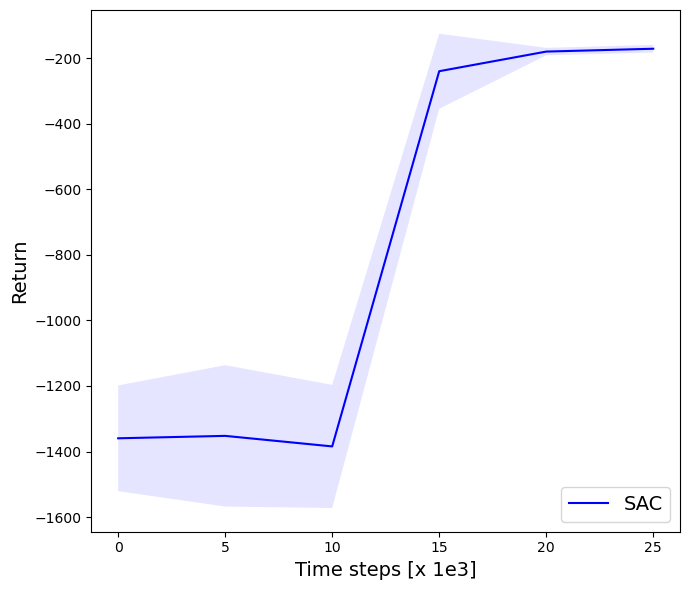

In [17]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

figure(figsize=(7, 6))

t = np.arange(0, int(args['total_step_num']) + 1, int(args['eval_step_freq'])) * 0.001

mean = np.mean(np.asarray(return_set), axis=0)
std = np.std(np.asarray(return_set), axis=0)
color = 'b'
label = 'SAC'
plt.plot(t, mean, color, label=label)
plt.fill(np.concatenate([t, t[::-1]]), np.concatenate([mean - 1.9600 * std,
                                      (mean + 1.9600 * std)[::-1]]), alpha=.1, fc=color, ec='None')

plt.xlabel('Time steps [x 1e3]', fontsize=14)
plt.ylabel('Return', fontsize=14)
plt.legend(loc='lower right', fontsize=14)


plt.tight_layout()
plt.show()